In [1]:
import pickle
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
from collections import defaultdict

In [5]:
data_dir = os.path.join("../../../data/embeddings/")
lsoas_file = os.path.join("../../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")

### Get spatial data

In [6]:
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA21NM'].str.contains(manc_lads_pattern)]
gm_lsoa = gm_lsoa.to_crs(epsg=4326)

### Get embeddings (four per location)

In [7]:
points_data_cache = data_dir + "sample_points_cache/points_data_cache_with_clip_multi_prompt.pkl"
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

### Join image embeddings points to gentrification LSOAs

In [8]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

# Perform spatial join to get gentrification label for each point
points_labels_gdf = gpd.sjoin(points_labels_gdf, gm_lsoa, how='inner', predicate='within')
# sjoin may add an index from the polygon ('index_right'); we can drop it
if 'index_right' in points_labels_gdf.columns:
    points_labels_gdf = points_labels_gdf.drop(columns=['index_right'])

print(f"Points after spatial join: {len(points_labels_gdf)} / {len(point_records)}"
      f" `(some points may lie outside the label polygons and were dropped)")

Points after spatial join: 18897 / 18897 `(some points may lie outside the label polygons and were dropped)


# Find mean embedding at each location.

In [9]:
points_labels_gdf["mean_embedding"] = points_labels_gdf["embedding"].apply(
    lambda emb_list: np.mean(np.stack(emb_list), axis=0)) 
# save
points_labels_gdf[['LSOA21CD', 'mean_embedding']].to_pickle(data_dir + "embedding_summaries/mean_embeddings_per_location_CLIP.pkl")

# Expand dataframe so there is one row per image

In [10]:
expanded_rows = []

for _, row in points_labels_gdf.iterrows():
    embeddings = row['embedding']      # list of 4 embeddings
    images = row['image_files']        # list of 4 image paths
    cat_scores = row['category_scores']        # list of 4 image paths
    
    # Skip if lengths don't match
    if len(embeddings) != len(images):
        print(f"Skipping row {row.name}: {len(embeddings)} embedding, {len(images)} images")
        continue

    for score, emb, img in zip(cat_scores, embeddings, images):
        new_row = row.to_dict()        # copy all other columns
        new_row['embedding'] = emb     # single embedding
        new_row['image_files'] = img    # single image
        new_row['category_scores'] = score
        expanded_rows.append(new_row)

# Create new DataFrame
expanded_gdf = pd.DataFrame(expanded_rows)
print(f"Original rows: {len(points_labels_gdf)}, Expanded rows: {len(expanded_gdf)}")
expanded_gdf = pd.DataFrame(expanded_rows)

Skipping row 9158: 3 embedding, 4 images
Skipping row 18664: 3 embedding, 4 images
Original rows: 18897, Expanded rows: 75580


# Look for outliers

In [40]:
import hdbscan 
from sklearn.ensemble import IsolationForest

all_embeddings = np.stack(expanded_gdf['embedding'].values)

# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=50,
#     min_samples=2,
#     metric='euclidean'
# ).fit(all_embeddings)

# scores = clusterer.outlier_scores_
hdb_outliers = scores > np.percentile(scores, 97)

# 2. Isolation Forest
# iso = IsolationForest(contamination=0.01).fit(all_embeddings)
iso_outliers = iso.predict(all_embeddings) == -1

# 3. Combined decision
final_outliers = np.where(hdb_outliers & iso_outliers)[0]
print(len(final_outliers))

108


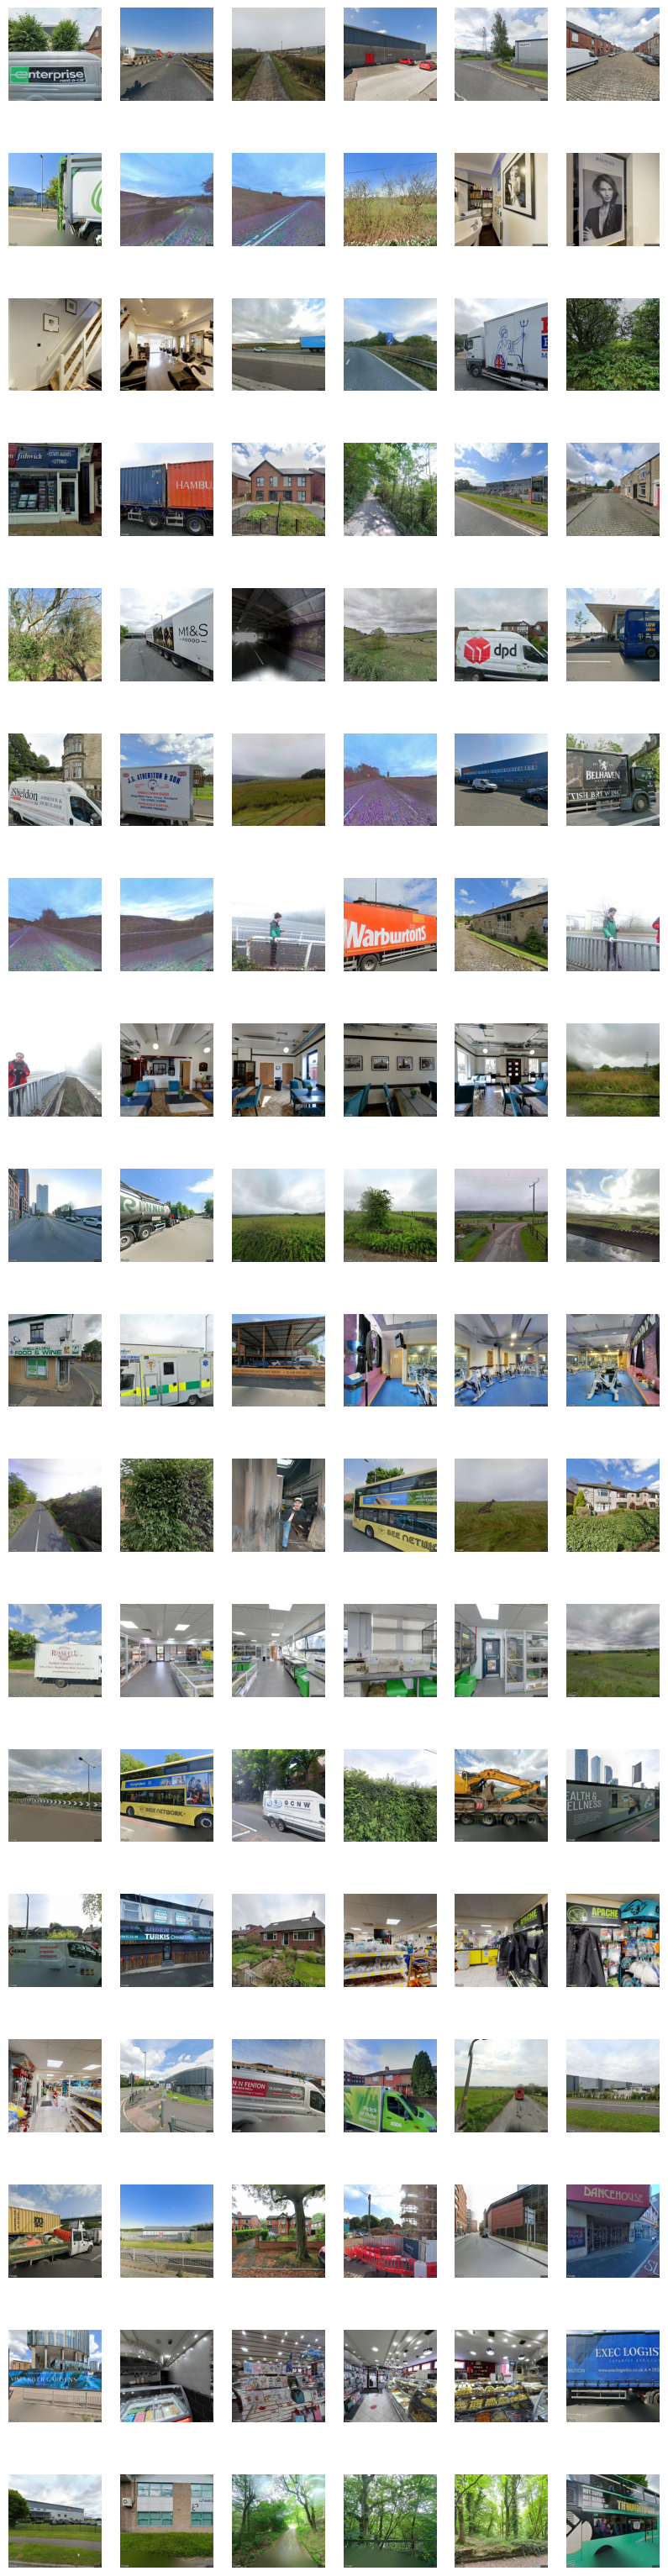

In [44]:
len(final_outliers)
fig,axs=plt.subplots(ncols=6, nrows=int(len(final_outliers)/6), figsize=(10,40))
axs=axs.flatten()
for i, outlier_i in enumerate(final_outliers):
    img_path = expanded_gdf.iloc[outlier_i]['image_files']
    adj_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../../")
    img = plt.imread(adj_path)
    axs[i].imshow(img)
    axs[i].axis("off")

# Assign each image to one classification, based on highest score

In [8]:
# Flatten all images across all points
all_image_paths = []
all_scores = []

for idx, rec in expanded_gdf.iterrows():
    all_image_paths.extend(rec["image_files"])
    all_scores.append(rec["category_scores"])

# Convert list of arrays → single (N,9) array
all_scores = np.vstack(all_scores)

# Define the category choices
headline_categories = ['indoor', 'terraced_house',  'semi_detached_house', 'residential_street',
 'urban_street', 'highway',  'shop', 'vehicle', 'industrial_building', 'wasteland', 'greenery']

category_probs = np.array(all_scores)
assigned_labels = category_probs.argmax(axis=1)
assigned_names = [headline_categories[i] for i in assigned_labels]
expanded_gdf['category'] = assigned_names

# Create a dataframe with % of images in each category, in each LSOA 

In [9]:
category_counts = (expanded_gdf.groupby(["LSOA21CD", "category"]).size().reset_index(name="count"))

# total images per LSOA
total_counts = (expanded_gdf.groupby("LSOA21CD").size().reset_index(name="total"))

# merge totals
category_counts = category_counts.merge(total_counts, on="LSOA21CD")
category_counts["pct"] = category_counts["count"] / category_counts["total"] * 100

# pivot to wide format: one column per category
category_pct_wide = category_counts.pivot(index="LSOA21CD", columns="category",  values="pct").fillna(0)

# Spatial plot of percentage in each category

In [10]:
# # merge with LSOA shapes
# plot_gdf = gm_lsoa.merge(category_pct_wide, on="LSOA21CD", how="left").fillna(0)

# # list of categories
# category_names = category_pct_wide.columns.tolist()

# # -------------------------
# # 2. Create subplots
# # -------------------------

# n = len(category_names)
# ncols = 3
# nrows = int(np.ceil(n / ncols))

# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5*nrows))
# axs = axs.flatten()

# for ax, category in zip(axs, category_names):
#     plot_gdf.plot(column=category, ax=ax, legend=True, cmap="viridis",
#         edgecolor="black",  linewidth=0.2, legend_kwds={"shrink": 0.5})
#     ax.set_title(f"{category} (%)")
#     ax.axis("off")

# # turn off any empty axes
# for empty_ax in axs[len(category_names):]:
#     empty_ax.axis("off")

# plt.tight_layout()
# plt.show()

# Find mean/median/max embedding in each LSOA, also by catgeory

In [11]:
# Aggregation functions
def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)

def max_embed(series):
    return np.max(np.stack(series.values), axis=0)

def median_embed(series):
    return np.median(np.stack(series.values), axis=0)

agg_funcs = {"mean": mean_embed, "max": max_embed, "median": median_embed}

# List of categories
categories = expanded_gdf['category'].unique()

# Initialize list to hold all DataFrames
all_dfs = []

for agg_name, func in agg_funcs.items():
    dfs = []
    
    # Per-category embeddings
    for cat in categories:
        df_cat = expanded_gdf[expanded_gdf['category'] == cat]
        emb_cat = df_cat.groupby("LSOA21CD")["embedding"].apply(func).reset_index()
        emb_cat = emb_cat.rename(columns={"embedding": f"{cat}_{agg_name}"})
        dfs.append(emb_cat)
    
    # Merge all categories
    merged = reduce(lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"), dfs)
    
    # Overall embedding (all images in LSOA)
    overall = expanded_gdf.groupby("LSOA21CD")["embedding"].apply(func).reset_index()
    overall = overall.rename(columns={"embedding": f"overall_{agg_name}"})
    
    merged = merged.merge(overall, on="LSOA21CD", how="left")
    
    all_dfs.append(merged)

# Merge mean, max, median into a single DataFrame
from functools import reduce
final_df = reduce(lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"), all_dfs)

# Fill missing embeddings with zeros if needed
final_df = final_df.fillna(0)

# Create one dataframe with all information

In [12]:
final_df = final_df.merge(category_pct_wide, on = "LSOA21CD")

In [13]:
final_df.to_pickle(data_dir + "embedding_summaries/big_summary_df_CLIP.pkl")